# Minimal use example of block coordinate forward-backward for image restoration
---

### Imports

In [ ]:
import torch
import deepinv as dinv
import matplotlib.pyplot as plt

from block import BlockCoordinateDescent
from utils.physics import BlurMatrix
from utils.matrix import create_gaussian_kernel_1d
from utils.plot_activations import plot_block_activation_matrix

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
PSNR = dinv.metric.PSNR()

### Load an image and initialize degradation

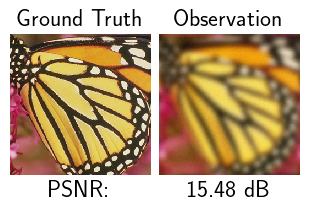

In [2]:
# Ground truth image
x_true = dinv.utils.load_example("butterfly.png", device=device)

# Wavelet parameters
J = 3
wv_type = "db8"

# Physics
filter_row = create_gaussian_kernel_1d(sigma=5, device=device, dtype=torch.float32) # Kernel along rows
filter_col = create_gaussian_kernel_1d(sigma=5, device=device, dtype=torch.float32) # Klur kernel along columns
physics = BlurMatrix(filter_row, filter_col, padding="circular", device=device)

sigma = 0.01
physics.noise_model = dinv.physics.GaussianNoise(sigma=sigma) # Additive Gaussian noise with standard deviation sigma

# Observation
y = physics(x_true)

# Visualize the ground truth and the observation
dinv.utils.plot([x_true.cpu(), y.cpu()], titles=["Ground Truth", "Observation"], subtitles=["PSNR:", f"{PSNR(x_true, y).item():.2f} dB"])

### Initialize algorithm parameters

In [ ]:
# Objective function
data_fidelity = dinv.optim.L2()
prior = dinv.optim.L1Prior()
reg_weight = 1e-5

# Parameters
n_iter = 100
Anorm2 = physics.compute_norm(x_true).item()
stepsize = 1.9 / Anorm2

bcd = BlockCoordinateDescent(
    x_true.shape,
    wv_type=wv_type,
    physics=physics,
    data_fidelity=data_fidelity,
    prior=prior,
    max_levels=J,
    stepsize=stepsize,
    device=device,
)

### Choose an update rule and run algorithm

In [ ]:
update_mode = "stochastic_gauss_southwell"

x0 = y.clone()
x_recon, loss, times, cycles, psnr = bcd.run(
    y,
    x0,
    x_true=x_true,
    n_iter=n_iter,
    reg_weight=reg_weight,
    update_mode='stochastic',
    distribution=update_mode,
    metrics=True,
    use_conditional_thresholding=False,
)

activated_blocks = bcd.updated_blocks_history

### Visualize activated blocks, convergence metrics, and reconstruction

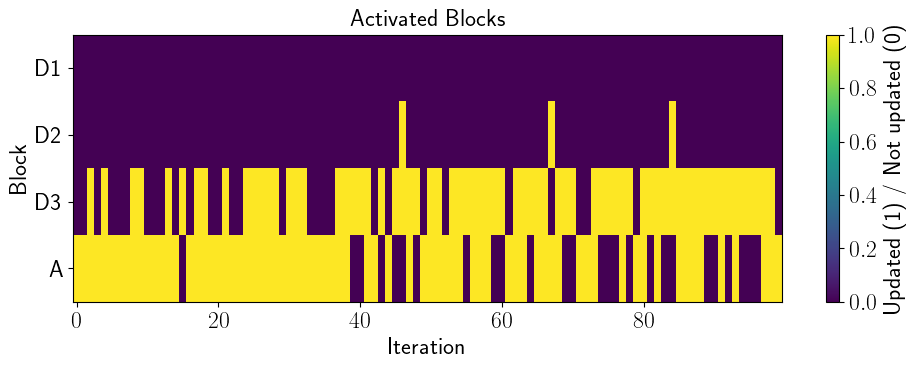

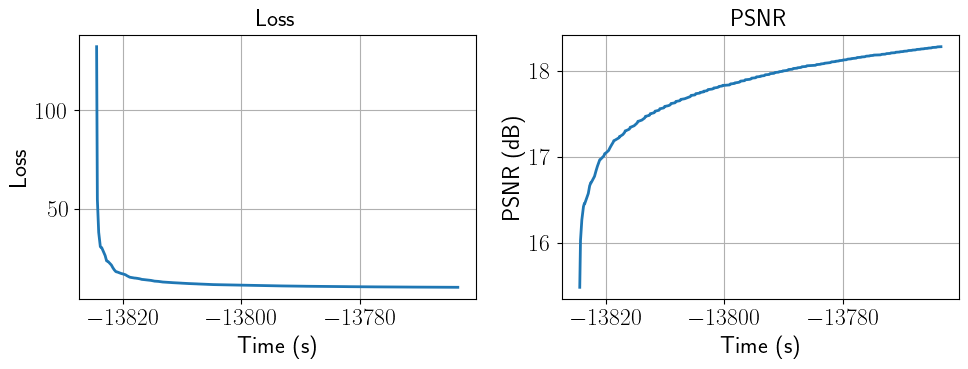

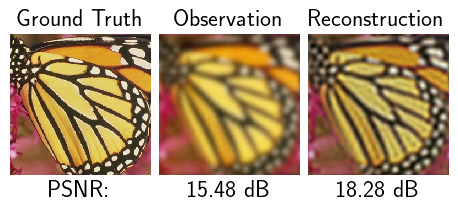

In [5]:
# Visualize the activated blocks
plot_block_activation_matrix(activated_blocks, J, title="Activated Blocks")

# Visualize the loss and PSNR curves
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# Loss
axes[0].plot(times, loss)
axes[0].set_title("Loss")
axes[0].set_xlabel("Time (s)")
axes[0].set_ylabel("Loss")
axes[0].grid()

# PSNR
axes[1].plot(times, psnr)
axes[1].set_title("PSNR")
axes[1].set_xlabel("Time (s)")
axes[1].set_ylabel("PSNR (dB)")
axes[1].grid()

plt.tight_layout()
plt.show()

# Visualize the ground truth, observation, and reconstruction
dinv.utils.plot([x_true.cpu(), y.cpu(), x_recon.cpu()], titles=["Ground Truth", "Observation", "Reconstruction"], subtitles=["PSNR:", f"{PSNR(x_true, y).item():.2f} dB", f"{PSNR(x_true, x_recon).item():.2f} dB"])